In [1]:
import pyreadstat
import pandas as pd
import numpy as np
import networkx as nx
import warnings
import itertools
from tqdm import tqdm
import seaborn as sns
import numpy as np

In [2]:
!dir ../../data/raw

OD_2017.dbf  Shape			      work_school_home_sp.feather
OD_2017.sav  work_school_home_sp_esc.feather


In [3]:
df, meta = pyreadstat.read_sav("../../data/raw/OD_2017.sav")
df.drop_duplicates(subset=['zona', 'zona_esc', 'zonatra1', 'id_pess'], inplace=True)

In [4]:
df = df[df['muni_dom'] == 36].copy()
max_zona = int(df.zona.max())

In [5]:
"""
1 - Agrícola
2 - Construção Civil
3 - Indústria
4 -Comércio
5 - Serviço de Transporte de Carga
6 - Serviço de Transporte de Passageiros
7 - Serviço Creditício-financeiro
8 - Serviço Pessoal
9 - Serviço de Alimentação
10 - Serviço de Saúde
11 - Serviço de Educação
12 - Serviço Especializado
13 - Serviço de Administração Pública
14 - Outros Serviços
"""

job_sector = {
    'essential' : [10],
    'high_impact': [1, 2, 3, 5, 6, 9],
    'regular': [4, 7, 8, 12, 13, 14],
    'education': [11]
}

In [6]:
def job_criticity(row):
    if row.setor1 in job_sector['essential'] or row.ocup1==10:
        return 4
    if row.setor1 in job_sector['high_impact']:
        return 3
    if row.setor1 in job_sector['regular']:
        return 2
    if row.setor1 in job_sector['education']:
        return -1
    return np.nan

In [7]:
df['job_level'] = df.apply(job_criticity, axis=1)

In [8]:
df[df['job_level'] == -1]

,zona,muni_dom,co_dom_x,co_dom_y,id_dom,f_dom,fe_dom,dom,cd_entre,data,...,modoprin,tipvg,pag_viag,tp_esauto,vl_est,pe_bici,via_bici,tp_estbici,id_ordem,job_level
23,1.0,36.0,333818.0,7394428.0,00010008,1.0,15.416667,8.0,1.0,06092017,...,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,24.0,-1.0
130,1.0,36.0,333458.0,7394389.0,00010040,0.0,30.038462,40.0,1.0,13092017,...,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,131.0,-1.0
137,1.0,36.0,333067.0,7394620.0,00010043,1.0,30.038462,43.0,1.0,06092017,...,4.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,138.0,-1.0
277,2.0,36.0,333381.0,7396181.0,00020312,1.0,34.678571,312.0,1.0,15062018,...,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,278.0,-1.0
380,2.0,36.0,333339.0,7396185.0,00020640,1.0,34.678571,640.0,1.0,11092018,...,16.0,3.0,NaN,NaN,NaN,1.0,NaN,NaN,381.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125890,342.0,36.0,322633.0,7391675.0,03420484,1.0,276.505586,484.0,1.0,24022018,...,16.0,3.0,NaN,NaN,NaN,1.0,NaN,NaN,125891.0,-1.0
125907,342.0,36.0,322891.0,7391254.0,03420515,1.0,276.505586,515.0,1.0,28022018,...,9.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,125908.0,-1.0
125920,342.0,36.0,323101.0,7392005.0,03420519,1.0,276.505586,519.0,1.0,08042018,...,4.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,125921.0,-1.0
125966,342.0,36.0,321930.0,7391013.0,03420932,1.0,276.505586,932.0,1.0,18082018,...,9.0,2.0,NaN,3.0,NaN,NaN,NaN,NaN,125967.0,-1.0


In [9]:
mask = df['job_level'] == -1
df.loc[mask, 'co_esc_x'] = df.loc[mask, 'co_tr1_x']
df.loc[mask, 'co_esc_y'] = df.loc[mask, 'co_tr1_y']
df.loc[mask, 'zona_esc'] = df.loc[mask, 'zonatra1']
df.loc[mask, 'zonatra1'] = np.nan
df.loc[mask, 'co_tr1_x'] = np.nan
df.loc[mask, 'co_tr1_y'] = np.nan

In [10]:
trab_esc = df[['zona', 'zona_esc', 'zonatra1', 'id_pess', 'co_tr1_x', 'co_tr1_y', 
               'co_esc_x', 'co_esc_y', 'co_dom_x', 'co_dom_y', 'id_dom', 'idade',
               'criteriobr', 'renda_fa', 'grau_ins', 'job_level', 'estuda']].copy()

trab_esc.rename(columns={'zona':'home', 'co_dom_x' : 'home_x', 'co_dom_y' : 'home_y',
                         'zona_esc':'school', 'co_esc_x' : 'school_x', 
                         'co_esc_y' : 'school_y', 'zonatra1':'work', 'estuda': 'studies',
                         'co_tr1_x': 'work_x', 'co_tr1_y': 'work_y', 'id_pess': 'id',
                         'id_dom': 'home_id', 'grau_ins': 'education'}, inplace=True)

trab_esc = trab_esc[~(trab_esc['work'] > max_zona) & 
        ~(trab_esc['school'] > max_zona) & ~(trab_esc['home'] > max_zona)].reset_index(drop=True)

In [11]:
p = df[df['co_esc_x'].notna()]['estuda'].value_counts().sort_index().values
p / np.sum(p)

array([0.12610324, 0.14255148, 0.33799144, 0.13994384, 0.21503076,
       0.03837925])

In [12]:
# Beneficiarios do Sistema de Saude Privado


#https://portal.cfm.org.br/images/PDF/leitosdeuticapitais2018.pdf
quantile = 1 - 5730524/12038175
print('Tem plano de saude aqueles com renda familiar superior a:')
print(np.quantile(trab_esc['renda_fa'], quantile))
print('Será???')

Tem plano de saude aqueles com renda familiar superior a:
4000.0
Será???


In [13]:
trab_esc.groupby(by='criteriobr')['renda_fa'].median()

criteriobr
1.0    11742.852070
2.0     6483.397776
3.0     4209.082629
4.0     2850.000000
5.0     2037.000000
6.0     1592.403836
Name: renda_fa, dtype: float64

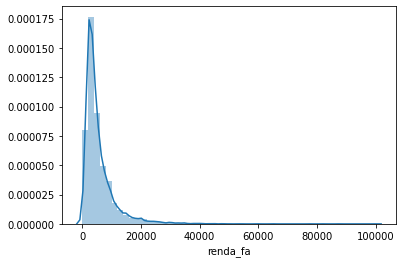

In [14]:
sns.distplot(trab_esc['renda_fa'])

In [15]:
def has_private_healthcare(family_income):
    return family_income >= 4000

trab_esc['private_healthcare'] = trab_esc['renda_fa'].apply(has_private_healthcare)

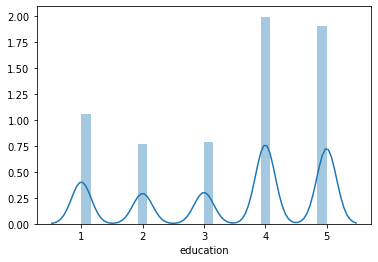

In [16]:
sns.distplot(trab_esc['education'])

In [17]:
trab_esc.to_feather("../../data/interim/work_school_home_sp_esc.feather")